# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier


---
## Step 0: Load The Data

In [1]:
# Load pickled data
import pickle

# TODO: Fill this in based on where you saved the training and testing data

training_file = "train.p"
validation_file= "valid.p"
testing_file = "test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

print("Finished Loading Data")

Finished Loading Data


---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES** 
---

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [2]:

import numpy as np

n_train = X_train.shape[0]

n_validation = X_valid.shape[0]

n_test = X_test.shape[0]

image_shape = X_train[0].shape

n_classes = np.unique(y_train).shape[0]

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Include an exploratory visualization of the dataset

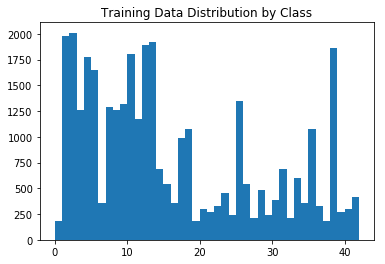

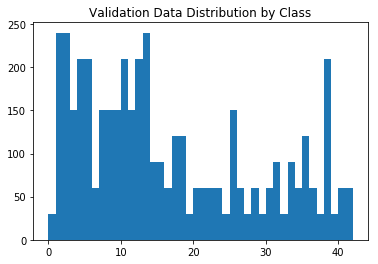

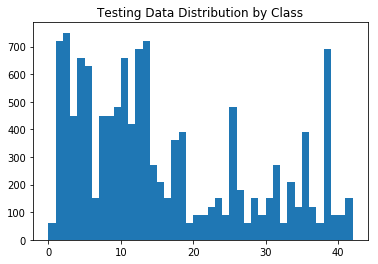

3


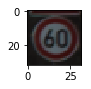

In [3]:

import matplotlib.pyplot as plt
%matplotlib inline

import random

# Distributions
binwidth = 1
plt.hist(y_train, bins=np.arange(min(y_train), max(y_train) + binwidth, binwidth))
plt.title("Training Data Distribution by Class")
plt.show()
plt.hist(y_valid, bins=np.arange(min(y_valid), max(y_valid) + binwidth, binwidth))
plt.title("Validation Data Distribution by Class")
plt.show()
plt.hist(y_test, bins=np.arange(min(y_test), max(y_test) + binwidth, binwidth))
plt.title("Testing Data Distribution by Class")
plt.show()

# Example image

index = random.randint(0, len(X_train))
image = X_train[index].squeeze()

plt.figure(figsize=(1,1))
plt.imshow(image)
print(y_train[index])




----

## Step 2: Design and Test a Model Architecture


### Pre-process the Data Set (normalization, grayscale, etc.)

Minimally, the image data should be normalized so that the data has mean zero and equal variance. For image data, `(pixel - 128)/ 128` is a quick way to approximately normalize the data and can be used in this project. 

Other pre-processing steps are optional. You can try different techniques to see if it improves performance. 

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project.

Original Dataset : 34799
Largest class has 2010 elements
Filling class 0 with 1830 elements
Class 0 has now 2010 elements
Filling class 1 with 30 elements
Class 1 has now 2010 elements
Filling class 2 with 0 elements
Class 2 has now 2010 elements
Filling class 3 with 750 elements
Class 3 has now 2010 elements
Filling class 4 with 240 elements
Class 4 has now 2010 elements
Filling class 5 with 360 elements
Class 5 has now 2010 elements
Filling class 6 with 1650 elements
Class 6 has now 2010 elements
Filling class 7 with 720 elements
Class 7 has now 2010 elements
Filling class 8 with 750 elements
Class 8 has now 2010 elements
Filling class 9 with 690 elements
Class 9 has now 2010 elements
Filling class 10 with 210 elements
Class 10 has now 2010 elements
Filling class 11 with 840 elements
Class 11 has now 2010 elements
Filling class 12 with 120 elements
Class 12 has now 2010 elements
Filling class 13 with 90 elements
Class 13 has now 2010 elements
Filling class 14 with 1320 elements
Class

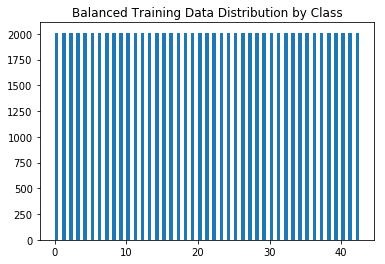

Finished Preprocessing Data


In [4]:
# Shuffle data
from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train)


# Normalize Data
X_train = (X_train - 128)/128
X_valid = (X_valid - 128)/128
X_test = (X_test - 128)/128

# Balance Data
import gc
def balance_data(train_x, train_y):
    """Makes ALL classes have the same distribution"""

    print('Original Dataset : {}'.format(train_x.shape[0]))

    max_count_index = np.bincount(train_y).argmax()
    max_count = np.where(train_y == max_count_index)[0].shape[0]
    
    print("Largest class has {} elements".format(max_count))

    xx = np.copy(train_x)
    yy = np.copy(train_y)

    #Over-Sampling
    for j in range(n_classes):
        mask_n = np.where(train_y == j)[0]
        num_to_oversample = max_count -  np.where(train_y == j)[0].shape[0]
        print("Filling class {} with {} elements".format(j,num_to_oversample))
        x_n = train_x[mask_n]
        y_n = train_y[mask_n]
        b_mask = np.random.RandomState().choice(x_n.shape[0], num_to_oversample)
        x_k = x_n[[b_mask]]
        y_k = y_n[[b_mask]]
        xx = np.concatenate((xx,x_k),axis=0)
        yy = np.concatenate((yy,y_k),axis=0)
        del x_n, y_n, x_k, y_k, mask_n, b_mask
        gc.collect()
        print("Class {} has now {} elements".format(j,np.where(yy == j)[0].shape[0]))

    print('Augmented Dataset : {}'.format(xx.shape[0]))
    
    return xx, yy

X_train, y_train = balance_data(X_train, y_train)

binwidth = 1
plt.hist(y_train, bins=np.arange(min(y_train), max(y_train) + binwidth, binwidth/2))
plt.title("Balanced Training Data Distribution by Class")
plt.show()

print("Finished Preprocessing Data")


### Model Architecture

In [5]:
import tensorflow as tf

EPOCHS = 512
BATCH_SIZE = 64

def LeNet(x):    
    conv1_W = tf.get_variable("conv1_W", shape = [5, 5, 3, 6], initializer = tf.contrib.layers.xavier_initializer())
    conv1_b = tf.get_variable("conv1_b", shape = [6], initializer = tf.contrib.layers.xavier_initializer())
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # SOLUTION: Activation.
    conv1 = tf.nn.relu(conv1)

    # SOLUTION: Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # SOLUTION: Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.get_variable("conv2_W", shape = [5, 5, 6, 16], initializer = tf.contrib.layers.xavier_initializer())
    conv2_b = tf.get_variable("conv2_b", shape = [16], initializer = tf.contrib.layers.xavier_initializer())
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # SOLUTION: Activation.
    conv2 = tf.nn.relu(conv2)

    # SOLUTION: Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # SOLUTION: Flatten. Input = 5x5x16. Output = 400.
    fc0   =  tf.contrib.layers.flatten(conv2)
    
    # SOLUTION: Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.get_variable("fc1_W", shape = [400, 120], initializer = tf.contrib.layers.xavier_initializer())
    fc1_b = tf.get_variable("fc1_b", shape = [120], initializer = tf.contrib.layers.xavier_initializer())
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # SOLUTION: Activation.
    fc1    = tf.nn.relu(fc1)

    # SOLUTION: Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W = tf.get_variable("fc2_W", shape = [120, 84], initializer = tf.contrib.layers.xavier_initializer())
    fc2_b = tf.get_variable("fc2_b", shape = [84], initializer = tf.contrib.layers.xavier_initializer())
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # SOLUTION: Activation.
    fc2    = tf.nn.relu(fc2)

    # SOLUTION: Layer 5: Fully Connected. Input = 84. Output = n_classes.
    fc3_W = tf.get_variable("fc3_W", shape = [84, n_classes], initializer = tf.contrib.layers.xavier_initializer())
    fc3_b = tf.get_variable("fc3_b", shape = [n_classes], initializer = tf.contrib.layers.xavier_initializer())
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits

def dnn(x):
    
    y = LeNet(x)
    
    return y

print("Finished Defining DNN")

Finished Defining DNN


### Train, Validate and Test the Model

In [ ]:
# Helper Definitions

print(tf.__version__)

x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, n_classes)

logits = dnn(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = 0.001)
training_operation = optimizer.minimize(loss_operation)

correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

print("Finished Loading Graph")

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

# Train & Validate

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})
            
        validation_accuracy = evaluate(X_valid, y_valid)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        saver.save(sess, 'model')
        
    saver.save(sess, 'model')
    print("Model saved")
    
    print("Testing...")
    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))
    sess.close()


0.12.1
Finished Loading Graph
Training...

EPOCH 1 ...
Validation Accuracy = 0.600

EPOCH 2 ...
Validation Accuracy = 0.683

EPOCH 3 ...
Validation Accuracy = 0.717

EPOCH 4 ...
Validation Accuracy = 0.736

EPOCH 5 ...
Validation Accuracy = 0.753

EPOCH 6 ...
Validation Accuracy = 0.761

EPOCH 7 ...
Validation Accuracy = 0.754

EPOCH 8 ...
Validation Accuracy = 0.761

EPOCH 9 ...
Validation Accuracy = 0.761

EPOCH 10 ...
Validation Accuracy = 0.763

EPOCH 11 ...
Validation Accuracy = 0.765

EPOCH 12 ...
Validation Accuracy = 0.737

EPOCH 13 ...
Validation Accuracy = 0.760

EPOCH 14 ...
Validation Accuracy = 0.778

EPOCH 15 ...
Validation Accuracy = 0.757

EPOCH 16 ...
Validation Accuracy = 0.778

EPOCH 17 ...
Validation Accuracy = 0.775

EPOCH 18 ...
Validation Accuracy = 0.778

EPOCH 19 ...
Validation Accuracy = 0.773

EPOCH 20 ...
Validation Accuracy = 0.763

EPOCH 21 ...
Validation Accuracy = 0.785

EPOCH 22 ...
Validation Accuracy = 0.774

EPOCH 23 ...
Validation Accuracy = 0.784



EPOCH 194 ...
Validation Accuracy = 0.815

EPOCH 195 ...
Validation Accuracy = 0.818

EPOCH 196 ...
Validation Accuracy = 0.806

EPOCH 197 ...
Validation Accuracy = 0.801

EPOCH 198 ...
Validation Accuracy = 0.786

EPOCH 199 ...
Validation Accuracy = 0.807

EPOCH 200 ...
Validation Accuracy = 0.808

EPOCH 201 ...
Validation Accuracy = 0.796

EPOCH 202 ...
Validation Accuracy = 0.800

EPOCH 203 ...
Validation Accuracy = 0.794

EPOCH 204 ...
Validation Accuracy = 0.798

EPOCH 205 ...
Validation Accuracy = 0.798

EPOCH 206 ...
Validation Accuracy = 0.804

EPOCH 207 ...
Validation Accuracy = 0.812

EPOCH 208 ...
Validation Accuracy = 0.810

EPOCH 209 ...
Validation Accuracy = 0.809

EPOCH 210 ...
Validation Accuracy = 0.799

EPOCH 211 ...
Validation Accuracy = 0.813

EPOCH 212 ...
Validation Accuracy = 0.795

EPOCH 213 ...
Validation Accuracy = 0.797

EPOCH 214 ...
Validation Accuracy = 0.795

EPOCH 215 ...
Validation Accuracy = 0.801

EPOCH 216 ...
Validation Accuracy = 0.800

EPOCH 217 .

EPOCH 385 ...
Validation Accuracy = 0.814

EPOCH 386 ...
Validation Accuracy = 0.817

EPOCH 387 ...
Validation Accuracy = 0.823

EPOCH 388 ...
Validation Accuracy = 0.822

EPOCH 389 ...
Validation Accuracy = 0.808

EPOCH 390 ...
Validation Accuracy = 0.815

EPOCH 391 ...
Validation Accuracy = 0.812

EPOCH 392 ...
Validation Accuracy = 0.804

EPOCH 393 ...
Validation Accuracy = 0.824

EPOCH 394 ...
Validation Accuracy = 0.818

EPOCH 395 ...
Validation Accuracy = 0.804

EPOCH 396 ...
Validation Accuracy = 0.814

EPOCH 397 ...
Validation Accuracy = 0.810

EPOCH 398 ...
Validation Accuracy = 0.819

EPOCH 399 ...
Validation Accuracy = 0.817

EPOCH 400 ...
Validation Accuracy = 0.808

EPOCH 401 ...
Validation Accuracy = 0.805

EPOCH 402 ...
Validation Accuracy = 0.815

EPOCH 403 ...
Validation Accuracy = 0.805

EPOCH 404 ...
Validation Accuracy = 0.808

EPOCH 405 ...
Validation Accuracy = 0.814

EPOCH 406 ...
Validation Accuracy = 0.814

EPOCH 407 ...
Validation Accuracy = 0.818

EPOCH 408 .

---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

In [ ]:
### Load the images and plot them here.
import matplotlib.image as mpimg
from scipy.misc import imresize
from random import randint

n_images = 5

X_data = np.random.rand(n_images, 32,32,3)

for  i in range(n_images):
    x =  mpimg.imread("images/{:05d}.ppm".format(randint(0,12000)))
    x = imresize(x, (32, 32))
    X_data[i] = x
    
X_data = (X_data - 128)/128

print("Data has shape {}".format(X_data.shape))

print("Finished loading images")

### Predict the Sign Type for Each Image

In [ ]:
encoded_vector = tf.nn.softmax(logits)

with tf.Session() as sess:
    saver.restore(sess,'model')
    for  i in range(X_data.shape[0]):
        probs = sess.run(encoded_vector, feed_dict={x: np.expand_dims(X_data[i],axis=0)})
        prediction = np.argmax(probs)
        print("Sign number {} is predicted to have class {}".format(i,prediction))
    sess.close()

### Analyze Performance

In [ ]:
with tf.Session() as sess:
    saver.restore(sess,'model')
    accuracy = evaluate(X_data, y_data)
    sess.close()
print("Accuracy = {:.3f}".format(accuracy))

### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tk.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

In [ ]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
### Feel free to use as many code cells as needed.